In [25]:
import numpy as np
import json
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=8) 

FONTSIZE=8

#plt.style.use('plot_style.txt')

DATA_LOCATION = '/Users/brendan/projects/problem_place/go/data/'


EXTINCTION_CUTOFF = 100
TRIALS = 1000
N = 1000

start = 0.0
end = 8.0
step = 0.1
X = np.arange(start, end + step, step)

linestyles = ['-', '--', ':']
colors = ["blue", "magenta", "red"]
descriptions = ['low variance', 'medium variance', 'high variance']
means = ['1/8', '1/4', '1/2']
titles = ["25% problem-place", "50% problem-place", "75% problem-place"]


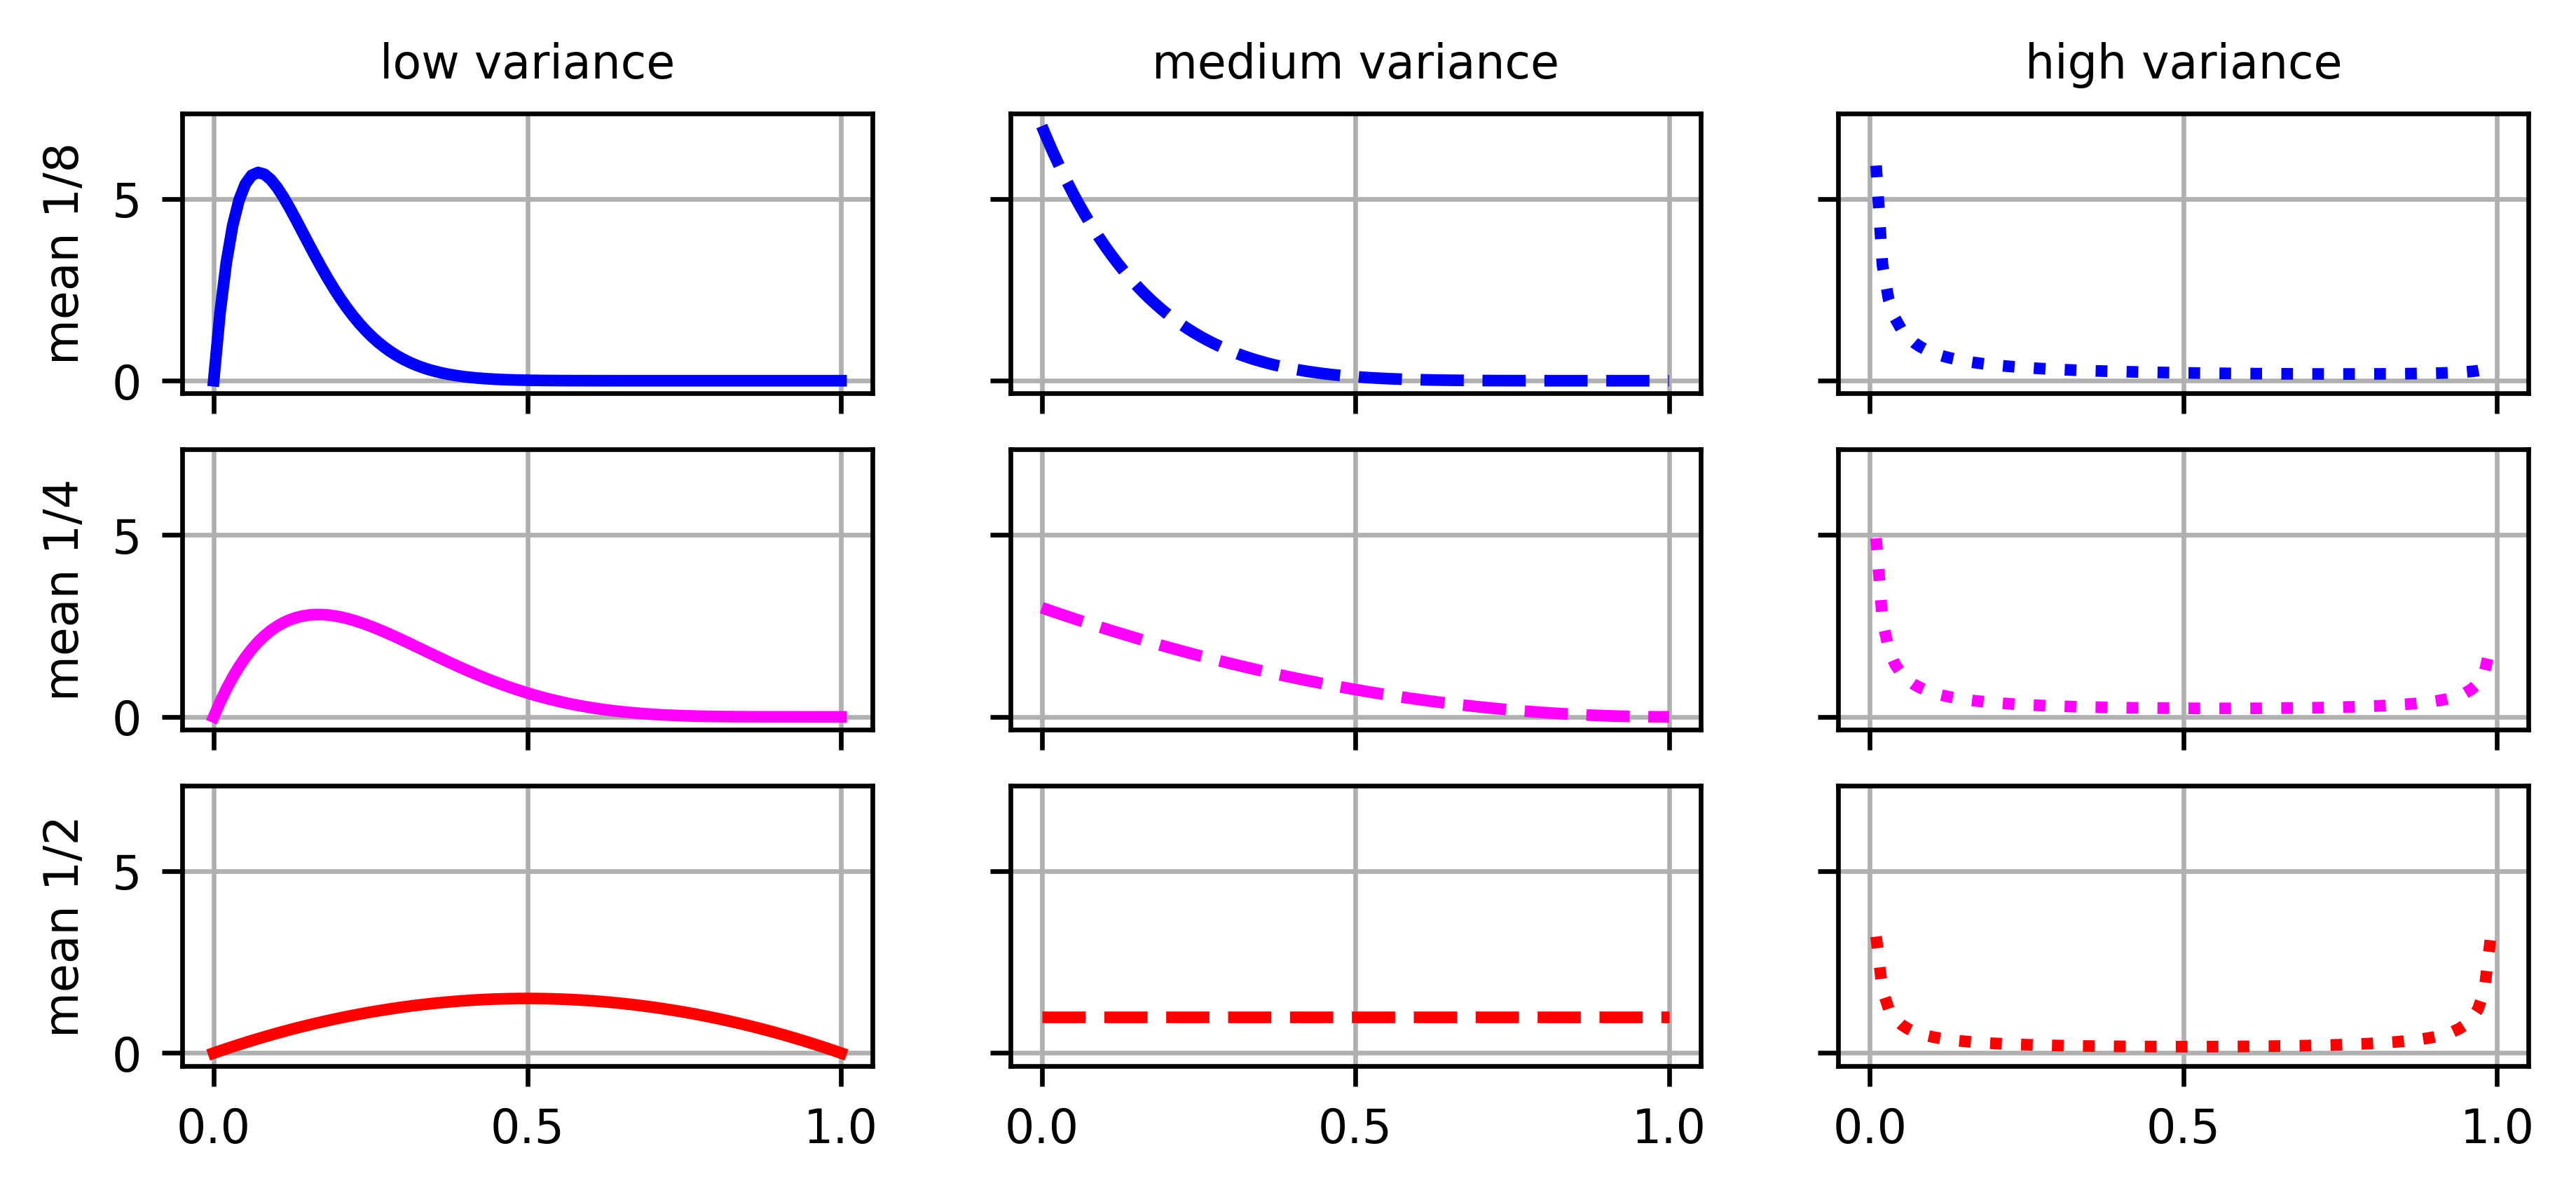

In [27]:
"""
Figure 1.

Risk Distributions
"""


fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(7.2, 3), dpi=600)
#fig.suptitle("Distributions of risk values")
bases = [(1, 7, "mean 1/8"), (1, 3, "mean 1/4"),  (1, 1, "mean 1/2")]
factors = [(2, "low variance"), (1, "medium variance"), (0.1, "high variance")]
for i, (a, b, desc_i) in enumerate(bases):
    for j, (f, desc_j) in enumerate(factors):
        

        x = np.linspace(0, 1, 100)

        g = stats.beta(f*a, f*b)
        axs[i][j].plot(x, g.pdf(x), lw=2, color=colors[i], linestyle=linestyles[j])
        if (i == 0):
            axs[i][j].set_title(desc_j, fontsize=FONTSIZE)
        if (j == 0):
            axs[i][j].set_ylabel(desc_i, fontsize=FONTSIZE)
        #plt.legend()
        axs[i][j].grid()

#g.std()
fig.savefig("risk_distributions.png")

In [6]:
def compute_g(alpha_c, alpha_r, mean_p, N=1000):
    """
    Computes theoretical extinction probability.
    """
    a, b, p = alpha_c, alpha_r, mean_p # makes the equation a little easier to write
    upper_g = 1
    lower_g = 0
    for T in range(1000):
        g = (upper_g + lower_g)/2
        g_ = p*(((1 - p*b)*(1 - a) + (1 - (1-p*b)*(1-a))*g)**N) + (1 - p)*((1 - a + a * g)**N)
        if g_ < g:
            upper_g = g
        else:
            lower_g = g
    return g

compute_g(1/1000., 0.1/1000., 0.5)

def compute_p0(a, b, p, N=1000):
    return p * ((1 - p * b) * (1 - a))**N + (1 - p)*((1 - a)**N)

gs = []
for R0 in X:
    gs.append(compute_g((R0)/N, 0, 0))


In [9]:
"""
Load all the data.
"""
all_data = {}
for filepart in ["75_25", "50_50", "25_75", "100_0"]:
    FILE = DATA_LOCATION + f'extinction_results_{filepart}.json'
    with open(FILE) as file:
        data = json.load(file)
    all_data[filepart] = data

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

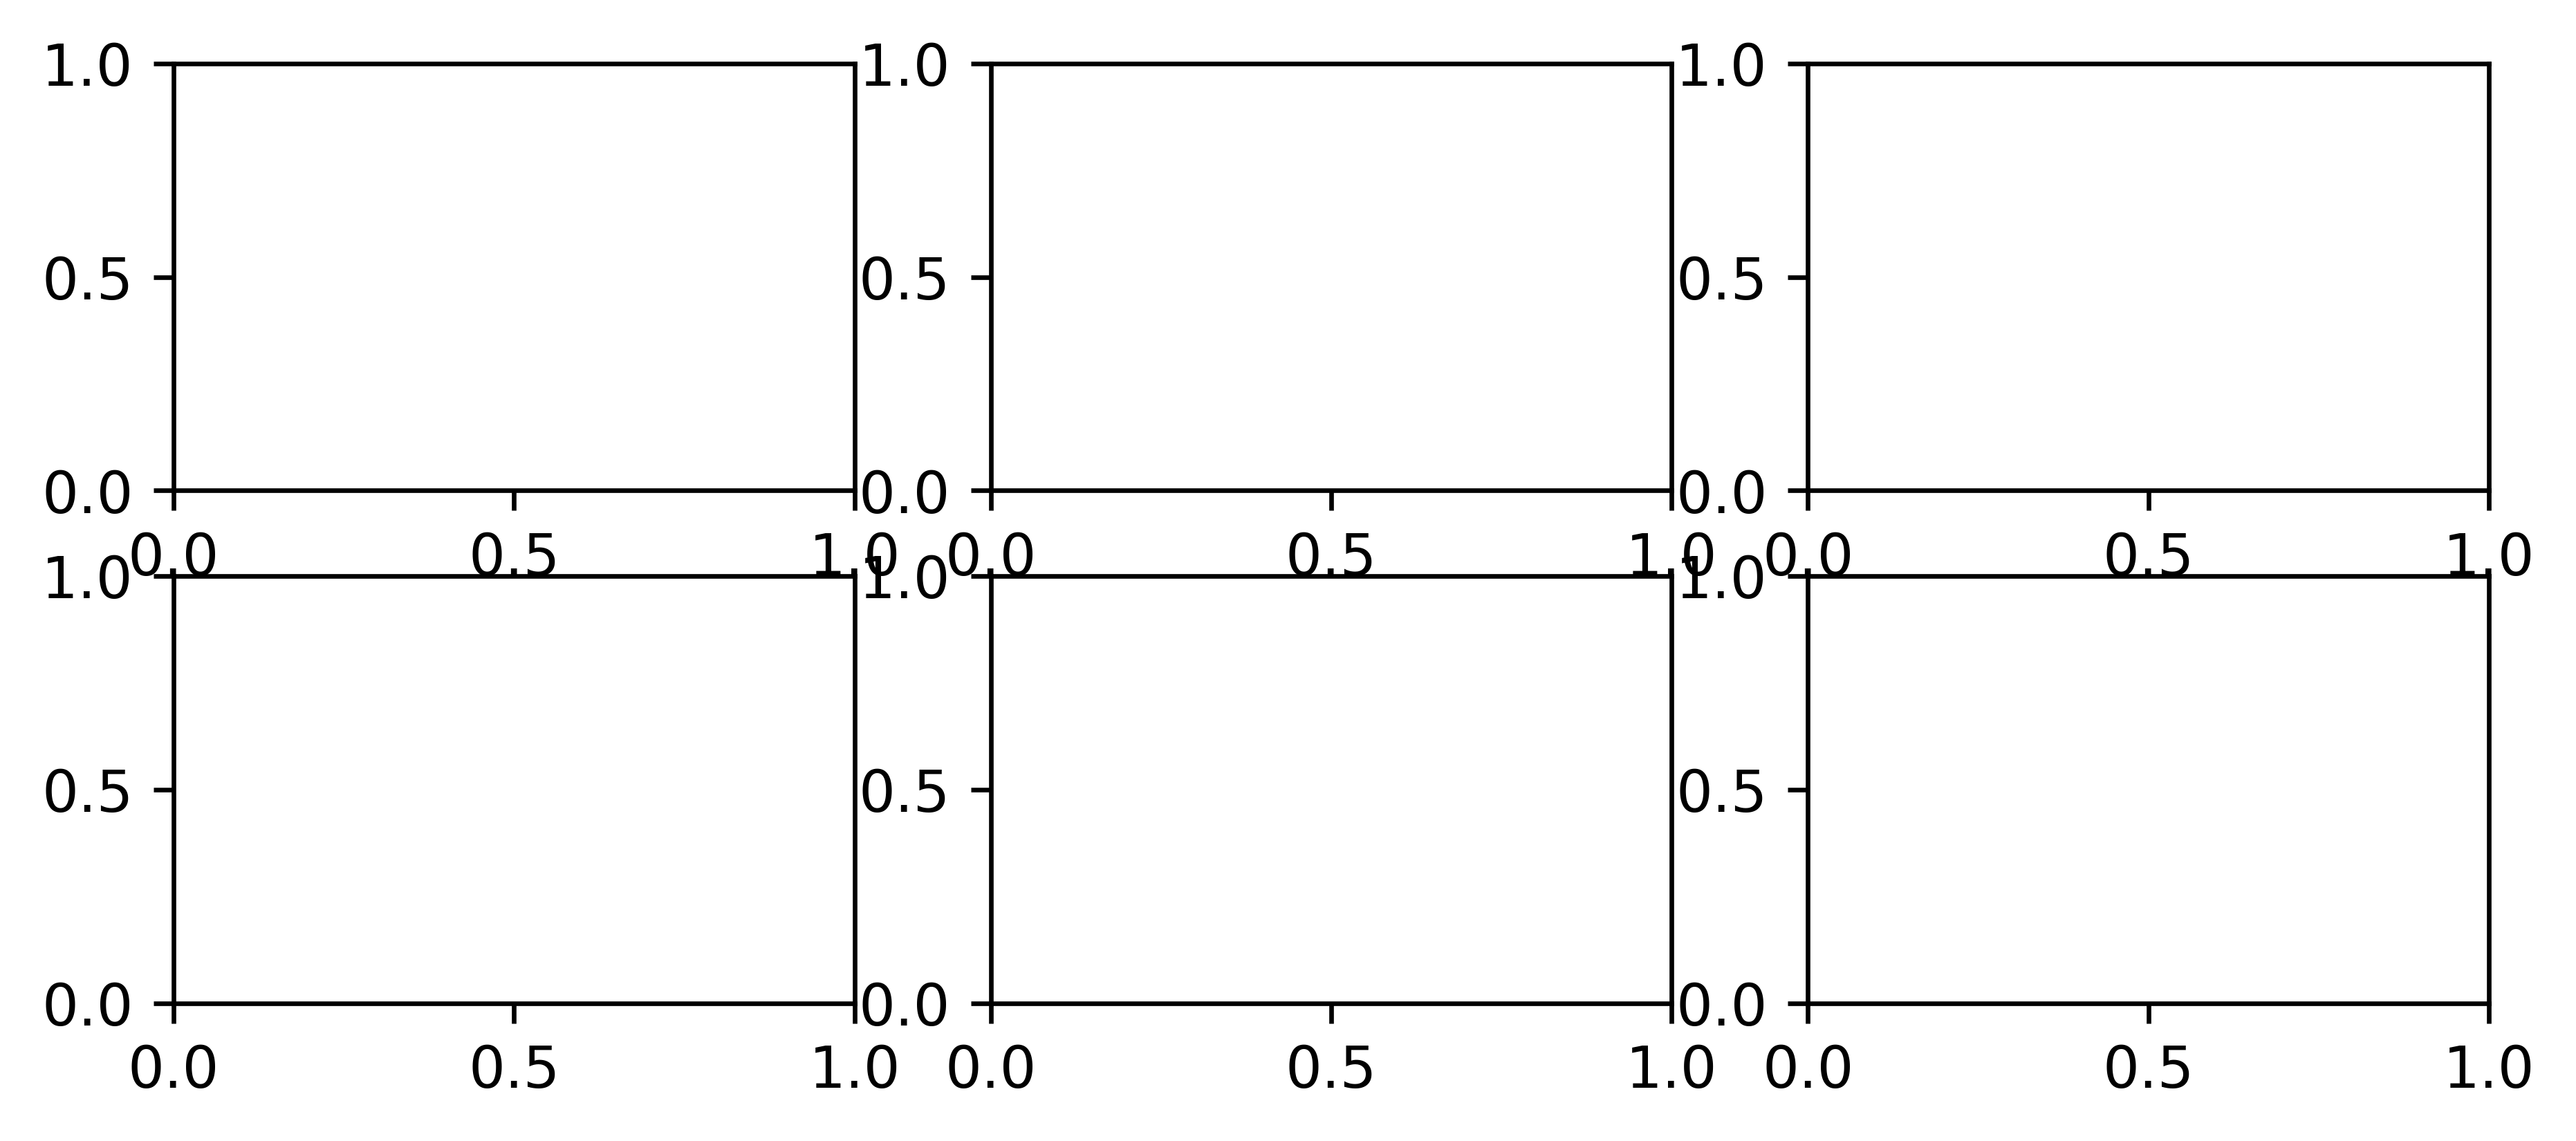

In [14]:
# Plots of extinction probability vs R0 for each of a couple mean riskyness

fig, axs = plt.subplots(2, 3, figsize=(7.2, 3), dpi=600)




for ax_, filepart in enumerate(["75_25", "50_50", "25_75"]):
    data = all_data[filepart]
    #ax1 = axs[0, ax_]
    ax2 = axs[ax_]
    for (k, dist) in enumerate(data):
        i = 2 - k//3
        j = 2 - (k%3)
        label = f'{means[i]} {descriptions[j]}'
        extinction_probs = []
        for tr in dist:
            extinction_probs.append(len([r for r in tr['SimulationResults']['FinalRs'] if r < EXTINCTION_CUTOFF])/N)
        ax1.plot(X, gs, label='homogeneous', color='black', linestyle='-')
        ax1.plot(X, extinction_probs, color=colors[i], linestyle=linestyles[j], label=label)
        ax2.plot(X, extinction_probs, color=colors[i], linestyle=linestyles[j], label=label, alpha=0.3)
    
    ax1.set_xlabel("R0")
    ax1.set_ylabel("Extinction probability")
    ax1.set_title(titles[ax_])
    ax1.label_outer()
    ax1.grid()
    ax.legend()



means = [0.5, 0.25, 0.125]
alpha_c_fractions = [0.75, 0.5, 0.25]
for (ax_, alpha_c_fraction) in enumerate(alpha_c_fractions):
    ax = axs[ax_]
    for m, mean in enumerate(means):
        gs_ = []
        for R0 in X:
            alpha_c = R0 / N * alpha_c_fraction
            alpha_r = R0 / N * (1 - alpha_c_fraction) / mean / mean
            gs_.append(compute_g(alpha_c, alpha_r, mean))
        ax.plot(X, gs_, color=colors[2 - m])
        ax.plot(X, gs, color='black', linestyle='-')
        ax.set_xlabel('R0')
        ax.set_ylabel('Extinction probability')
        ax.label_outer()
        ax.set_title(titles[ax_])
        ax.grid()
fig.savefig("images/extinction_explained")

In [17]:
def compute_r(R0, N=1000):
    """
    Computes expected number of final infections.
    """
    upper_r = 1
    lower_r = 0
    for T in range(1000):
        r = (upper_r + lower_r)/2
        r_ = (1 - np.exp(-R0 * r))
        if r_ < r:
            upper_r = r
        else:
            lower_r = r
    return r*N

compute_r(2)

796.8121300200202

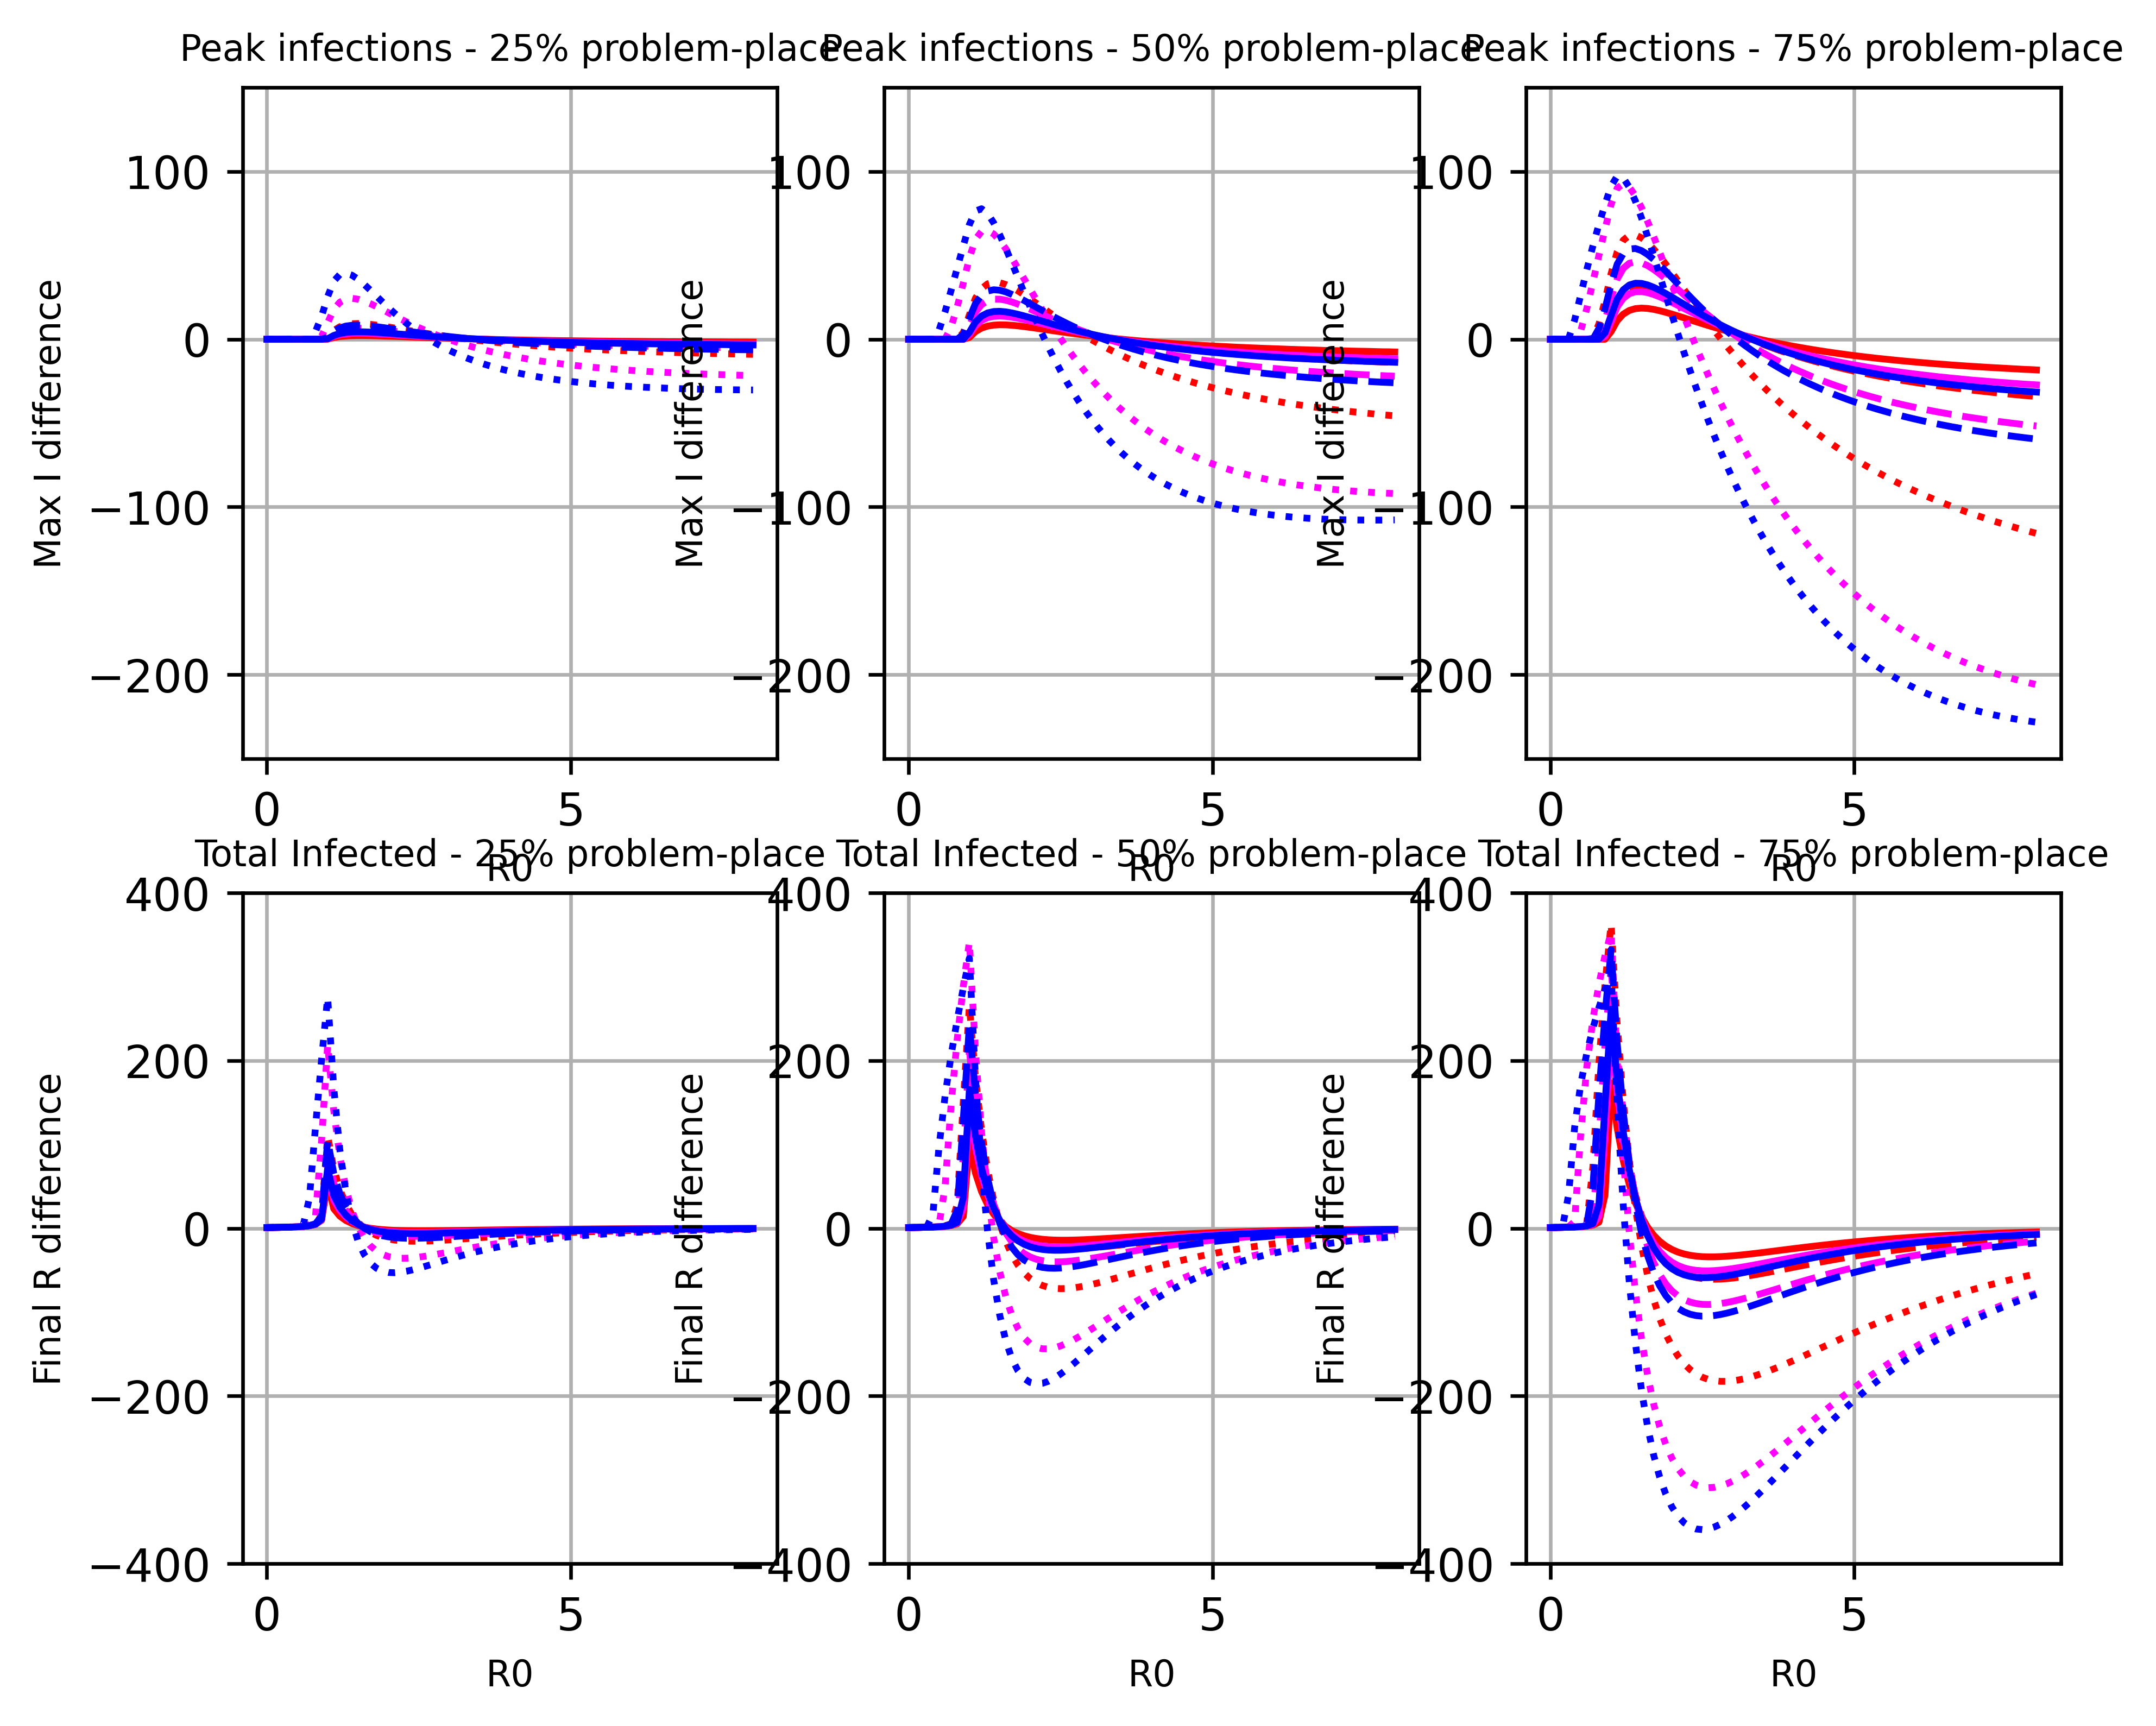

In [24]:
"""
Theoretical peak infections - from difeq
"""

FONTSIZE=8

i_s = []
data = all_data["100_0"]
dist = data[0]
for tr in dist:
    i_s.append(tr['DifEqResults']['MaxI'])

    
rs = [compute_r(x) for x in X]

fig, axs = plt.subplots(2, 3, figsize=(7.2, 6), dpi=600)


start = 0.0
end = 8.0
step = 0.1
X = np.arange(start, end + step, step)

## Max I
for ax_, filepart in enumerate(["75_25", "50_50", "25_75"]):
    data = all_data[filepart]
    ax = axs[0, ax_]
    for (k, dist) in enumerate(data):
        i = 2 - k//3
        j = 2 - (k%3)
        label = f'{means[i]} {descriptions[j]}'
        max_Is = []
        for (x, tr) in enumerate(dist):
            max_Is.append((tr['DifEqResults']['MaxI'] - i_s[x]))
        ax.plot(X, max_Is, color=colors[i], linestyle=linestyles[j], label=label)
    #plt.plot(R0s, gs, label='homogeneous', color='black', linestyle='-.')
    #plt.legend()
    ax.set_ylim((-250, 150))
    ax.set_title("Peak infections - " + titles[ax_], fontsize=FONTSIZE)
    ax.set_xlabel("R0", fontsize=FONTSIZE)
    ax.set_ylabel("Max I difference", fontsize=FONTSIZE)
    ax.grid()
    #ax.label_outer()
    
    
    
"""
Final size difference vs homogeneous case
"""

for (ax_, filepart) in enumerate(["75_25", "50_50", "25_75"]):
    data = all_data[filepart]
    ax = axs[1, ax_]
    for (k, dist) in enumerate(data):
        i = 2 - k//3
        j = 2 - (k%3)
        label = f'{means[i]} {descriptions[j]}'
        FinalRs = []
        for (x, tr) in enumerate(dist):
            FinalRs.append((tr['DifEqResults']['FinalR'] - rs[x]))
        ax.plot(X, FinalRs, color=colors[i], linestyle=linestyles[j], label=label)
    #plt.plot(X, rs, label='homogeneous', color='black', linestyle='-.')
    #plt.legend()
    ax.set_title("Total Infected - " + titles[ax_], fontsize=FONTSIZE)
    ax.set_xlabel("R0", fontsize=FONTSIZE)
    ax.set_ylabel("Final R difference", fontsize=FONTSIZE)
    ax.set_ylim((-400, 400))
    ax.grid()
    #ax.label_outer()

fig.savefig("outbreakresults.png")

these should be the R0s we're looking for:
0.0011999999999999997
0.002
0.004000000000000001


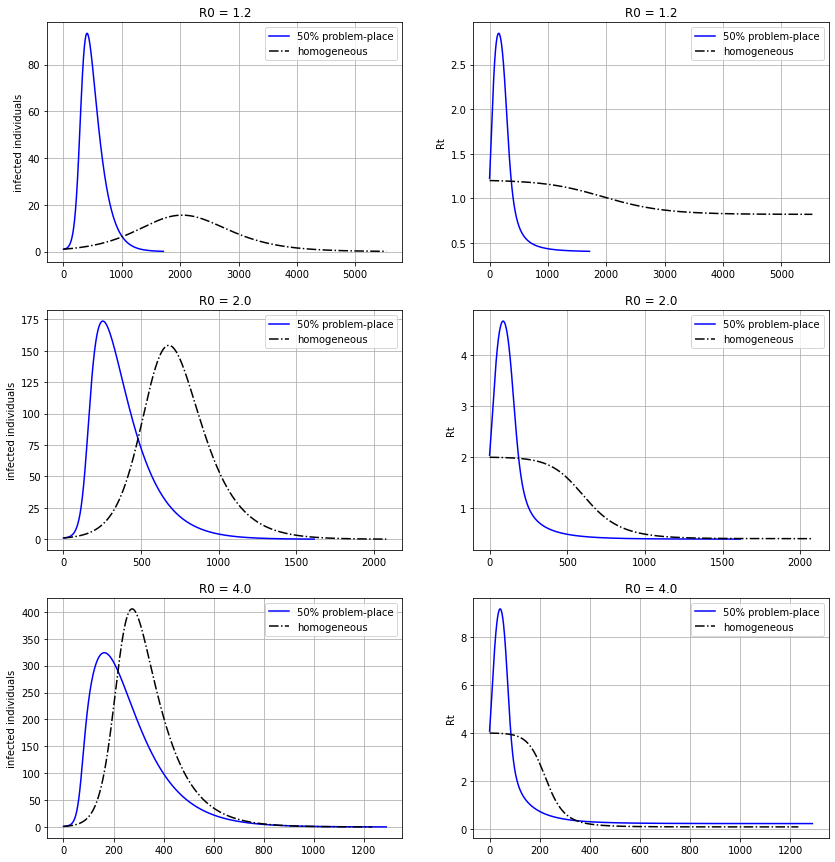

In [94]:
fig, axs = plt.subplots(3, 2, figsize=(14, 15))

# index into risk distributions to get to dashed blue – p=1/8, medium var
risk_distribution_index = 6
data_ = all_data["50_50"][risk_distribution_index]
homogeneous_ = all_data["100_0"][0]
# assert data_[0]['Parameters']['RiskDist']['A'] == 1
# assert data_[0]['Parameters']['RiskDist']['B'] == 7

step_size = 0.1 # step size of R0 increases, to find R0

print("these should be the R0s we're looking for:")
for i, R0 in enumerate([1.2, 2.0, 4.0]):
    index = round(R0/0.1)
    risk_trial = data_[index]
    homogeneous_trial = homogeneous_[index]
    print(risk_trial['Parameters']['AlphaC'] + risk_trial['Parameters']['AlphaR']*0.125*0.125)
    
    axs[i, 0].plot(risk_trial['DifEqResults']['Is'], color=colors[0], linestyle=linestyles[0], label="50% problem-place")
    axs[i, 0].plot(homogeneous_trial['DifEqResults']['Is'], color='black', linestyle='-.', label="homogeneous")
    axs[i, 0].set_title(f'R0 = {R0}')
    axs[i, 0].set_ylabel('infected individuals')
    axs[i, 0].grid()
    axs[i, 0].legend()
    
    axs[i, 1].plot(risk_trial['DifEqResults']['Rts'], color=colors[0], linestyle=linestyles[0], label="50% problem-place")
    axs[i, 1].plot(homogeneous_trial['DifEqResults']['Rts'], color='black', linestyle='-.', label="homogeneous")
    axs[i, 1].set_title(f'R0 = {R0}')
    axs[i, 1].set_ylabel('Rt')
    axs[i, 1].grid()
    axs[i, 1].legend()

    
#     axs[i, 1].plot([r / 10 for r in risk_trial['DifEqResults']['RiskyInfections']])
#     axs[i, 1].plot([r / 10 for r in risk_trial['DifEqResults']['CommunityInfections']])
    #axs[i, 2].plot([a + b for a, b in zip(risk_trial['DifEqResults']['CommunityInfections'], risk_trial['DifEqResults']['RiskyInfections'])])
fig.savefig("dynamics_comparison.png")

In [22]:
data_[0]['Parameters']

{'RiskDist': {'A': 1, 'B': 7},
 'AlphaDist': None,
 'AlphaC': 0,
 'AlphaR': 0,
 'DiseaseLength': 1,
 'N': 1000,
 'Trials': 1000,
 'Intervention': None,
 'Caution': False}